In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
import itertools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import os
from src.features.build_features import calculate_columns

In [7]:
cwd = os.getcwd()
root_dir = os.path.dirname(cwd)
loan_default_df = pd.read_csv(root_dir + "/data/raw/Loan_defaults/Loan_default.csv")
loan_default_df = calculate_columns(loan_default_df)

In [11]:
#loan_default_df["TotalRepayable"] = loan_default_df["LoanAmount"]*(1 + loan_default_df["InterestRate"]/1200)**loan_default_df["LoanTerm"]

In [8]:
palette = itertools.cycle(sns.color_palette())

# Fix random generator seed for reproducibility
np.random.seed(42)

# Matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


# Convert categorical variables to numeric
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']

loan_default_df = pd.get_dummies(loan_default_df, columns=categorical_columns, drop_first=False)
loan_default_df = pd.get_dummies(loan_default_df, columns=binary_columns, drop_first=True)

#categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 
 #                      'HasDependents', 'LoanPurpose', 'HasCoSigner']
#label_encoders = {col: LabelEncoder() for col in categorical_columns}

#for col in categorical_columns:
    #loan_default_df[col] = label_encoders[col].fit_transform(loan_default_df[col])

# Normalize numerical features
numerical_columns = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                        'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 
                         "LoanToIncomeRatio", "YearsEmployed", "LoanTermYears", 
                         "TotalPayment", "TotalInterest", "MonthlyPayment",
                         "RemainingIncomeAfterPayment", "InterestToPrincipalRatio"]
scaler = StandardScaler()
#loan_default_df[numerical_columns] = scaler.fit_transform(loan_default_df[numerical_columns])

# Split the data into training and test sets
X = loan_default_df.drop(columns=['LoanID', 'Default'])
y = loan_default_df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [4]:
loan_default_df.head(10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasMortgage_Yes,HasDependents_Yes,HasCoSigner_Yes
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,0,0,0,0,0,0,1,1,1,1
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,1,0,0,0,0,0,1,0,0,1
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,0,0,1,0,0,0,0,1,1,0
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,1,0,0,1,0,0,0,0,0,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,0,0,1,0,0,0,0,0,1,0
5,A9S62RQ7US,25,90298,90448,720,18,2,22.72,24,0.10,...,0,1,0,1,0,0,0,1,0,1
6,H8GXPAOS71,38,111188,177025,429,80,1,19.11,12,0.16,...,0,1,0,0,0,1,0,1,0,1
7,0HGZQKJ36W,56,126802,155511,531,67,4,8.15,60,0.43,...,1,0,0,0,0,1,0,0,0,1
8,1R0N3LGNRJ,36,42053,92357,827,83,1,23.94,48,0.20,...,0,0,0,0,1,0,0,1,0,0
9,CM9L1GTT2P,40,132784,228510,480,114,4,9.09,48,0.33,...,1,0,0,0,0,0,1,1,0,1


In [11]:
loan_encoding = pd.get_dummies(loan_default_df, columns = ["Education", ], drop_first=True)
loan_encoding = pd.get_dummies(loan_encoding, columns = ["EmploymentType", ], drop_first=False)

In [12]:
loan_encoding 

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,TotalPayment,TotalInterest,MonthlyPayment,RemainingIncomeAfterPayment,InterestToPrincipalRatio,LoanToIncomeRatio2,Education_0,Education_1,Education_2,Education_3
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,77399.046500,26812.046500,2149.973514,83844.026486,0.530019,0.196087,1,0,0,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,157388.721437,32948.721437,2623.145357,47808.854643,0.264776,0.493496,0,0,1,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,189676.003585,60488.003585,7903.166816,76304.833184,0.468217,0.767077,0,0,1,0
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,51357.505954,6558.505954,2139.896081,29573.103919,0.146398,0.706319,0,1,0,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,11761.432381,2622.432381,245.029841,20191.970159,0.286950,0.111795,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,...,240409.230200,29727.230200,20034.102517,17944.897483,0.141100,5.547329,1,0,0,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,...,236298.969135,46399.969135,9845.790381,42107.209619,0.244340,1.827604,0,1,0,0
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,...,269533.275143,61239.275143,4492.221252,80327.778748,0.294004,0.491144,0,1,0,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,...,129419.174769,68844.174769,2696.232808,82412.767192,1.136511,0.177934,0,1,0,0


In [4]:
loan_default_df[["DTIRatio", 'LoanToIncomeRatio1', 'LoanToIncomeRatio2']]

,DTIRatio,LoanToIncomeRatio1,LoanToIncomeRatio2
0,0.44,0.588262,0.196087
1,0.68,2.467481,0.493496
2,0.31,1.534154,0.767077
3,0.23,1.412638,0.706319
4,0.73,0.447179,0.111795
...,...,...,...
255342,0.85,5.547329,5.547329
255343,0.21,3.655208,1.827604
255344,0.50,2.455718,0.491144
255345,0.44,0.711734,0.177934


In [60]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [76]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train-1)

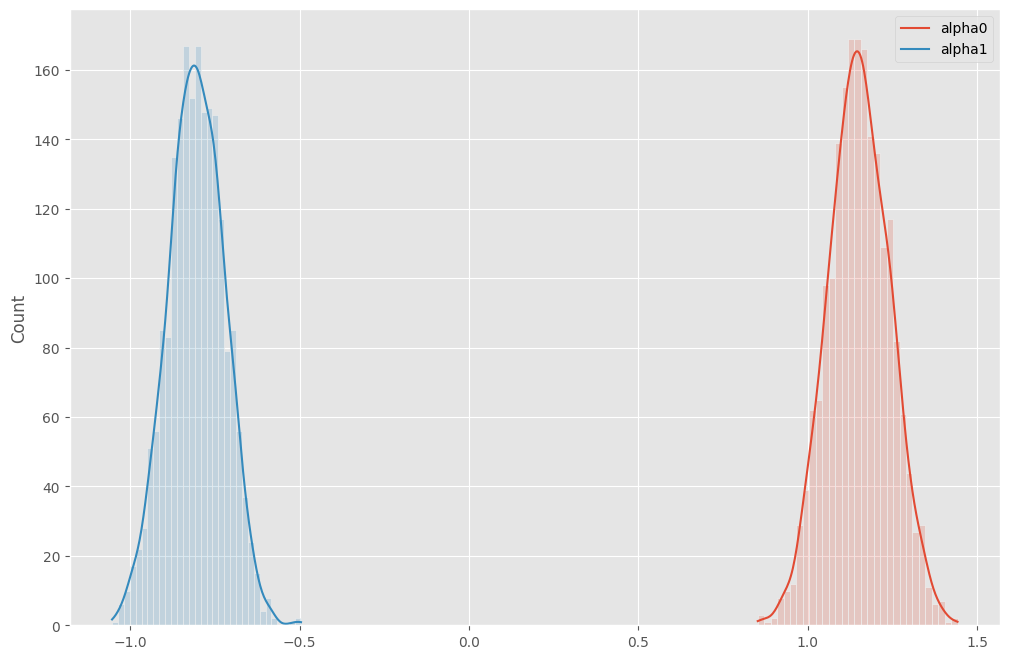

In [77]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

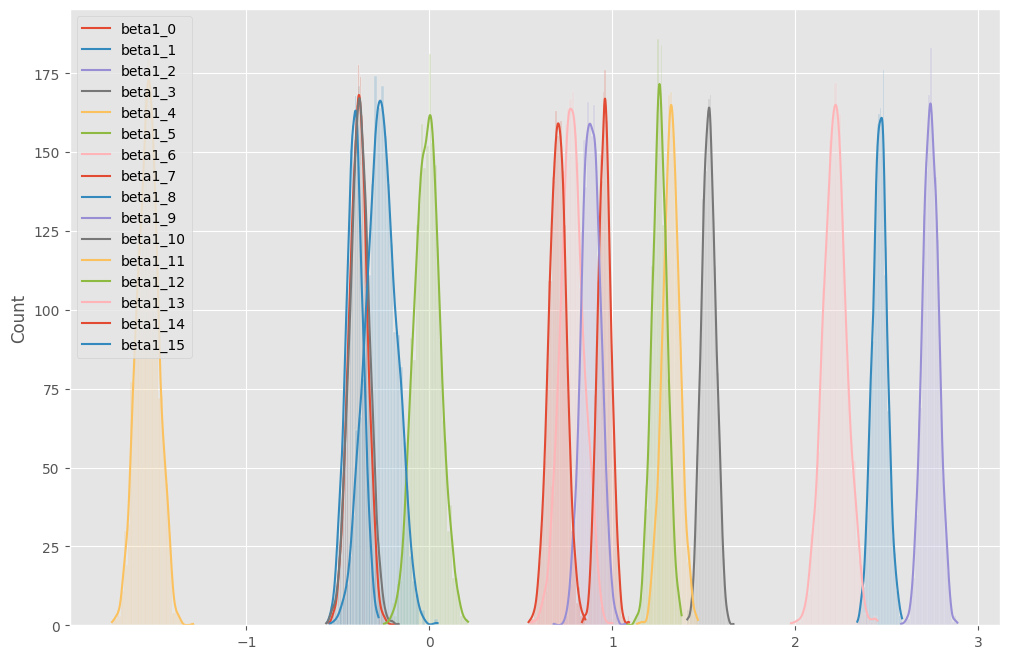

In [78]:
samples_beta = samples['beta'].detach().squeeze()
for d in range(X.shape[1]):
    sns.histplot(samples_beta[:,d,0], kde=True, alpha=0.2)
plt.legend(["beta1_%d" % d for d in range(X.shape[1])])
plt.show()

In [79]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

In [83]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat != y_test) / len(y_test))

predictions: [1 1 1 ... 1 1 1]
true values: 51139     0
71005     0
35684     0
174087    0
137952    0
         ..
35991     0
69680     0
184743    0
209406    0
123164    0
Name: Default, Length: 51070, dtype: int64
Accuracy: 0.8879772860779322


In [84]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if (step % 1000 == 0):
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 408691.8


KeyboardInterrupt: 

In [75]:
y_hat

array([-3.23558958, -2.92110602, -2.20350067, ..., -2.27885436,
       -2.01577463, -3.69090039])

In [73]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

In [ ]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1

In [71]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=0)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: 45884
true values: 51139     0
71005     0
35684     0
174087    0
137952    0
         ..
35991     0
69680     0
184743    0
209406    0
123164    0
Name: Default, Length: 51070, dtype: int64
Accuracy: 0.0


In [69]:
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Accuracy: 0.0


In [55]:
y_hat

array([-3.23558958, -2.92110602, -2.20350067, ..., -2.27885436,
       -2.01577463, -3.69090039])

In [57]:
# make predictions for test set
y_hat = torch.sigmoid(alpha_hat + np.dot(X_test, beta_hat))
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
samples = np.load("/zhome/58/f/181392/DTU/MBML/european_vote_analysis/src/data/samples.csv.npz")

: 

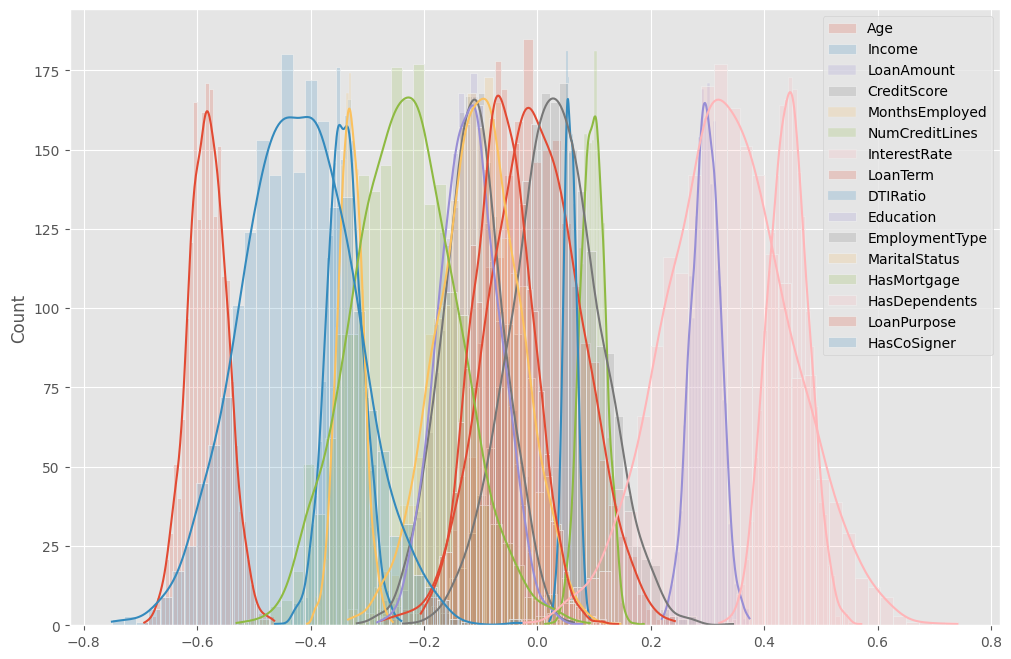

In [34]:
samples_beta = samples['beta'].detach().squeeze()
for d in range(X.shape[1]):
    sns.histplot(samples_beta[:,d], kde=True, alpha=0.2, label=X.columns[d])
plt.legend()
plt.show()

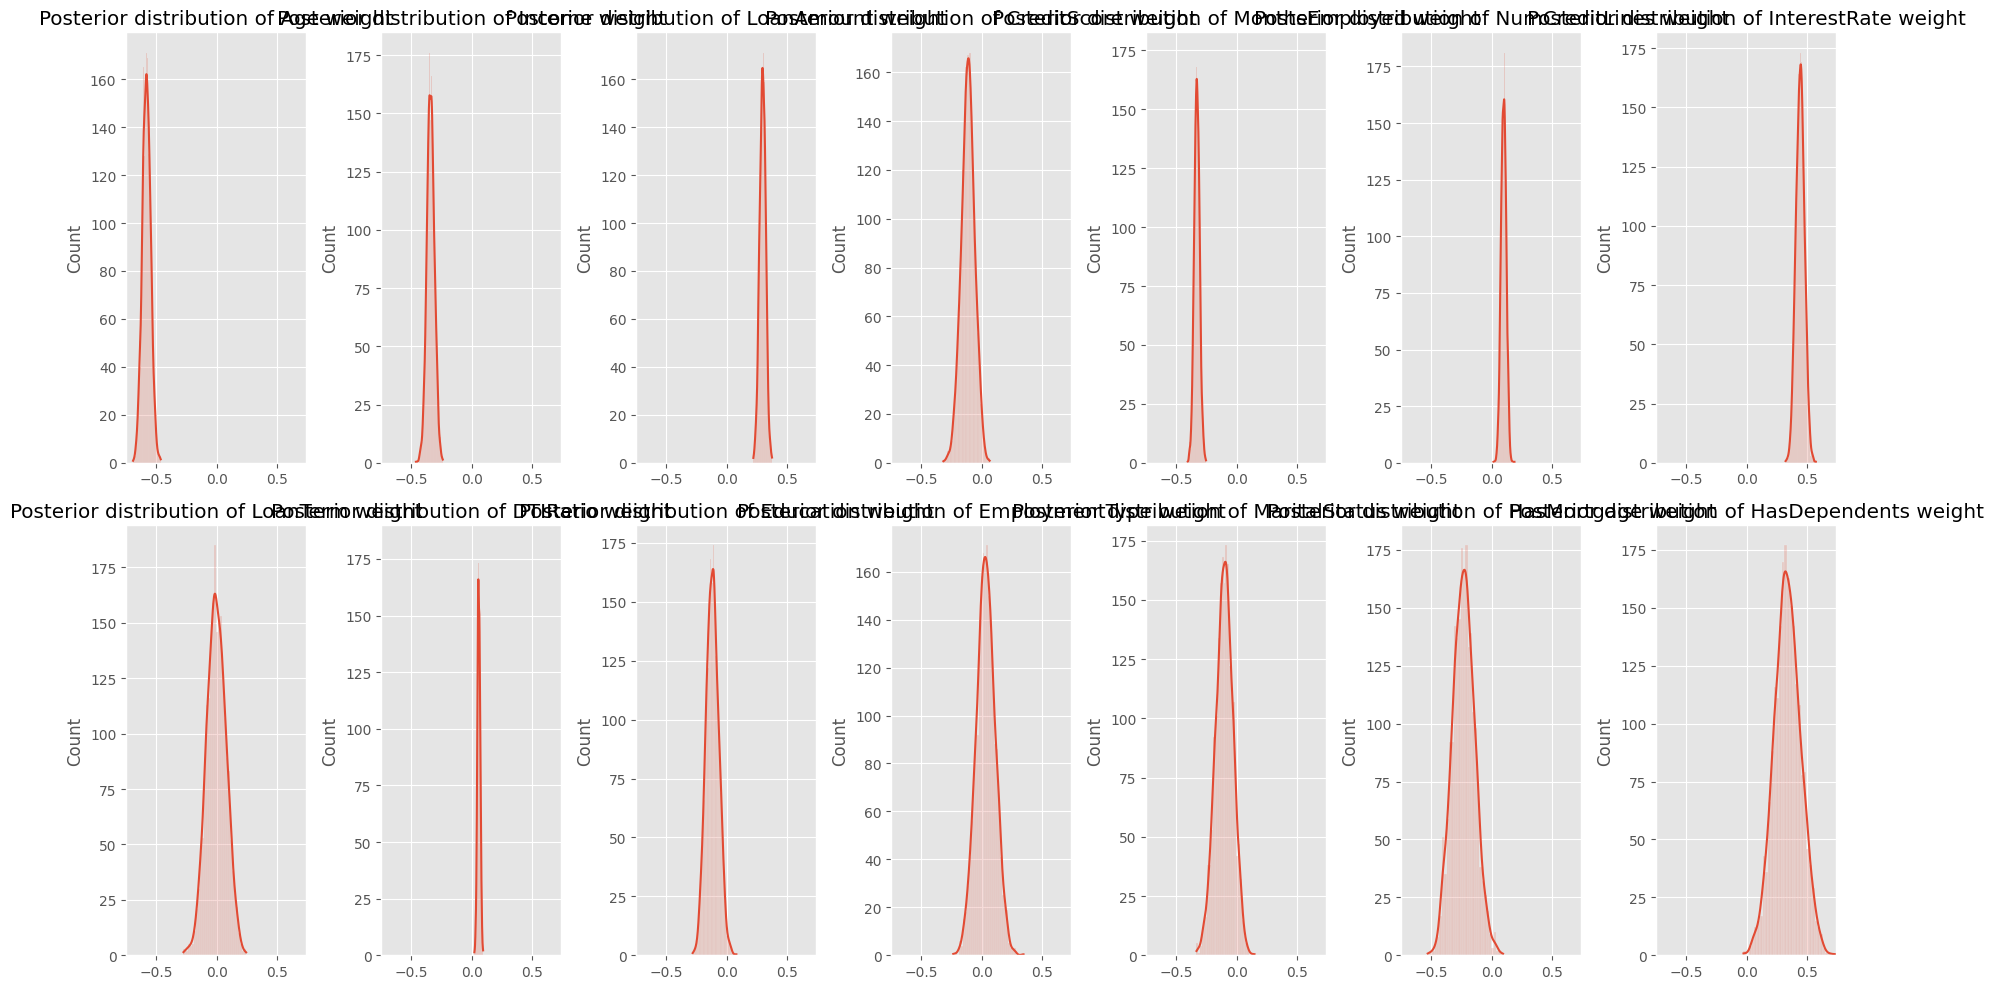

In [39]:
samples_beta = samples['beta'].detach().squeeze()

# Plot the posterior distributions of the weights (beta) with feature names
num_features = X.shape[1]
num_cols = 7
# num_rows = (num_features + num_cols - 1) // num_cols
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 5))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.set_xlim(samples_beta.min(), samples_beta.max())
    if i < num_features:
        sns.histplot(samples_beta[:, i], kde=True, alpha=0.2, ax=ax)
        ax.set_title(f"Posterior distribution of {X.columns[i]} weight")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
